### Imports & Preparation

In [1]:
import sys
sys.path.insert(1, '../')  # to load from any submodule in the repo

from models3D import detector, predictor
from utils import dpcr_utils, dpcr_generator
import utils.readOBJ as reader

import torch
import numpy as np
import scipy as sp
import scipy.spatial
import matplotlib
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("cpu")

if torch.device("cuda"):
    device = torch.device("cuda")
    print("Using", torch.cuda.device_count(), "CUDA devices")

seed_file = open('../utils/seed.txt', "r")
seed = int(seed_file.read())
seed_file.close()

print ("Using Seed:", seed)
    
torch.manual_seed(seed)
np.random.seed(seed)

Using 1 CUDA devices
Using Seed: 34897567


### Checkpoint Loading

In [2]:
detector = detector.Model(k = 10, emb_dims = 1024, dropout = 0.5).to(device)
detector = torch.nn.DataParallel(detector)

predictor = predictor.Model(k = 20, emb_dims = 1024, dropout = 0.5).to(device)
predictor = torch.nn.DataParallel(predictor)

detector_checkpoint = torch.load('../models3D/detector_model_e60.t7')
predictor_checkpoint = torch.load('../models3D/predictor_model_e20.t7')

detector.load_state_dict(detector_checkpoint['model_state_dict'][-1])
print ("> Loaded detector model (%d epochs)" % detector_checkpoint['train_settings'][-1]['epochs'])

predictor.load_state_dict(predictor_checkpoint['model_state_dict'][-1])
print ("> Loaded predictor model (%d epochs)" % predictor_checkpoint['train_settings'][-1]['epochs'])

_ = detector.eval()
_ = predictor.eval()

> Loaded detector model (60 epochs)
> Loaded predictor model (20 epochs)


### Test Model Generation

In [3]:
test_size_per_model = 10
test_data = []
test_models = [
    'data/models/faces/clean/face_01_clean.obj',
    'data/models/faces/clean/face_02_clean.obj'
]

for model_path in test_models:
    
    print ("Processing model %s.." % (model_path))
    
    start = time.time()
    
    model, _ = reader.readOBJ("../%s" % (model_path))
    
    model = torch.from_numpy(model).float().to(device)
    
    # mean centering
    model = model - torch.mean(model, dim = 0)
    
    # scaling to fit 2x2x2 bounding box
    min_vals, _ = torch.min(model, dim = 0)
    max_vals, _ = torch.max(model, dim = 0)
    scale = torch.max(torch.abs(min_vals),  torch.abs(max_vals))
    model = model / scale
    
    for sample in dpcr_generator.getData(model, test_size_per_model):
        test_data.append(model[sample[:, 0]])
    
    print ("   ..done! (%.1fs)" % (time.time() - start))

print ("Generated %d Test Models" % (len(test_data)))
print ("Total Time:", time.time() - start)

Processing model data/models/faces/clean/face_01_clean.obj..
   ..done! (3.1s)
Processing model data/models/faces/clean/face_02_clean.obj..
   ..done! (2.7s)
Generated 174 Test Models
Total Time: 2.6775035858154297


torch.Size([7229, 3])


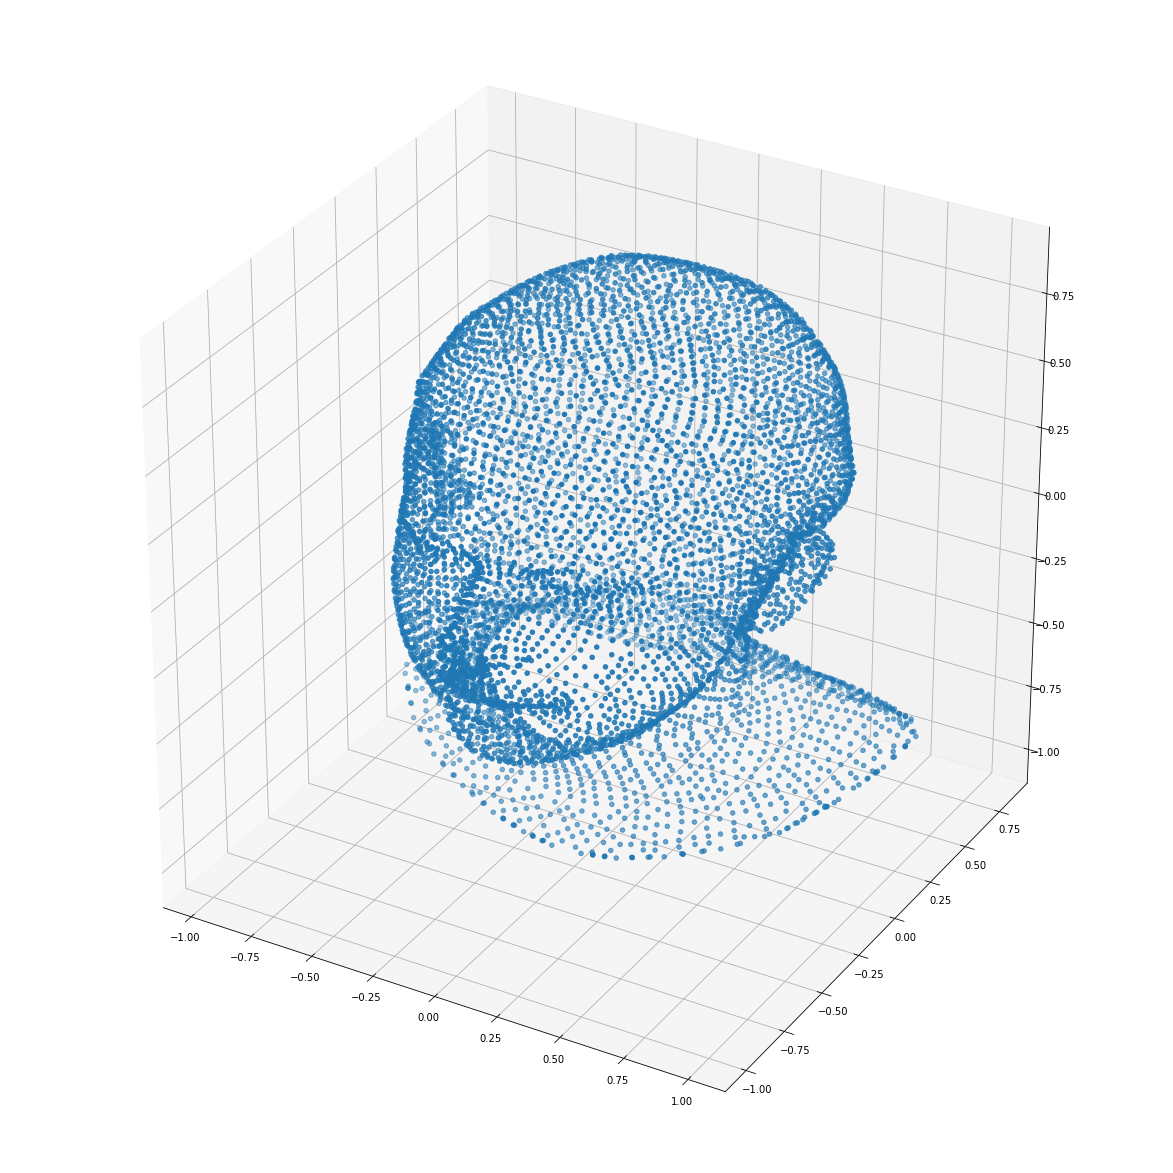

In [4]:
fig = plt.figure(figsize=(16,16))
ax = Axes3D(fig)

sample = test_data[np.random.randint(len(test_data))]
print (sample.shape)

sample_np = sample.cpu().numpy()

#edge_pts = sample[sample[:, 6] == True, 0:3]
#non_edge_pts = sample[sample[:, 6] == False, 0:3]

#ax.scatter(non_edge_pts[:,0], non_edge_pts[:,1], non_edge_pts[:,2])
#ax.scatter(edge_pts[:,0], edge_pts[:,1], edge_pts[:,2])

ax.scatter(sample_np[:,0], sample_np[:,1], sample_np[:,2])

plt.show()

### Evaluation Methods

In [5]:
def getClusterPoints(pts, threshold):
    
    neighbor_index = sp.spatial.distance.cdist(pts, pts) < threshold
    
    groups = []
    
    for i in range(neighbor_index.shape[0]):
        
        group = None
        
        # check if point exists in another group
        for k in range(len(groups)):
            if i in groups[k]:
                group = k
                break
                
        if group == None:
            
            groups.append(np.nonzero(neighbor_index[i, :].reshape(-1))[0].tolist())
            
        else:
            
            groups[group] += np.nonzero(neighbor_index[i, :].reshape(-1))[0].tolist()
                
    
    cluster_pts = np.zeros((len(groups), pts.shape[1]))
    for i in range(len(groups)):
        cluster_pts[i] = np.mean(pts[groups[i]], axis = 0)

    return cluster_pts

In [10]:
entry = test_data[np.random.randint(0, len(test_data))]

#origin_points = np.copy(entry[:,0:3])

points = entry.cpu().numpy()
print (points.shape)
extra_points = []

iteration_count = 0

for i in range(20):
    
    pts = torch.from_numpy(np.swapaxes(np.expand_dims(points, axis = 0), 1,2)).float().to(device)
    
    edge_points_prediction = detector(pts).squeeze(0).transpose(0,1)
    new_points_prediction = predictor(pts).squeeze(0).transpose(0,1)
    
    new_points_prediction_np = new_points_prediction.detach().cpu().numpy()
    
    edge_points_prediction_np = edge_points_prediction.detach().cpu().numpy()
    edge_points_prediction_np = np.argmax(edge_points_prediction_np, axis = 1).astype(bool)
    
    del pts
    del edge_points_prediction
    del new_points_prediction
    
    iteration_count += 1
    
    if not np.any(edge_points_prediction_np):
        
        break
        
    else:
        
        print (edge_points_prediction_np.shape)
        print (np.repeat(points, 6, 1).shape)
        print (new_points_prediction_np.shape)

        new_points = (np.repeat(points, 6, 1) + new_points_prediction_np)[edge_points_prediction_np].reshape((-1, 3))
        
        print (new_points.shape)
 
        dists = sp.spatial.distance.cdist(new_points, points)
    
        
    
        new_points = new_points[np.amin(dists >= 0.05, axis = 1).astype(bool)]
        
        new_points = getClusterPoints(new_points, 0.05)
        
        if new_points.shape[0] == 0:
            
            break
        
        else:
        
            extra_points.append(new_points)
            points = np.concatenate((points, new_points), axis = 0)
        

print ("Ran %d iterations!" % (iteration_count))

(7096, 3)
(7096,)
(7096, 18)
(7096, 18)
(390, 3)
(7143,)
(7143, 18)
(7143, 18)
(282, 3)
(7167,)
(7167, 18)
(7167, 18)
(426, 3)
(7173,)
(7173, 18)
(7173, 18)
(456, 3)
(7178,)
(7178, 18)
(7178, 18)
(498, 3)
(7180,)
(7180, 18)
(7180, 18)
(504, 3)
(7181,)
(7181, 18)
(7181, 18)
(504, 3)
(7182,)
(7182, 18)
(7182, 18)
(510, 3)
(7184,)
(7184, 18)
(7184, 18)
(522, 3)
(7186,)
(7186, 18)
(7186, 18)
(534, 3)
(7190,)
(7190, 18)
(7190, 18)
(558, 3)
(7191,)
(7191, 18)
(7191, 18)
(564, 3)
(7194,)
(7194, 18)
(7194, 18)
(570, 3)
(7197,)
(7197, 18)
(7197, 18)
(582, 3)
(7199,)
(7199, 18)
(7199, 18)
(594, 3)
(7202,)
(7202, 18)
(7202, 18)
(624, 3)
(7206,)
(7206, 18)
(7206, 18)
(648, 3)
(7211,)
(7211, 18)
(7211, 18)
(672, 3)
(7216,)
(7216, 18)
(7216, 18)
(702, 3)
(7219,)
(7219, 18)
(7219, 18)
(714, 3)
Ran 20 iterations!


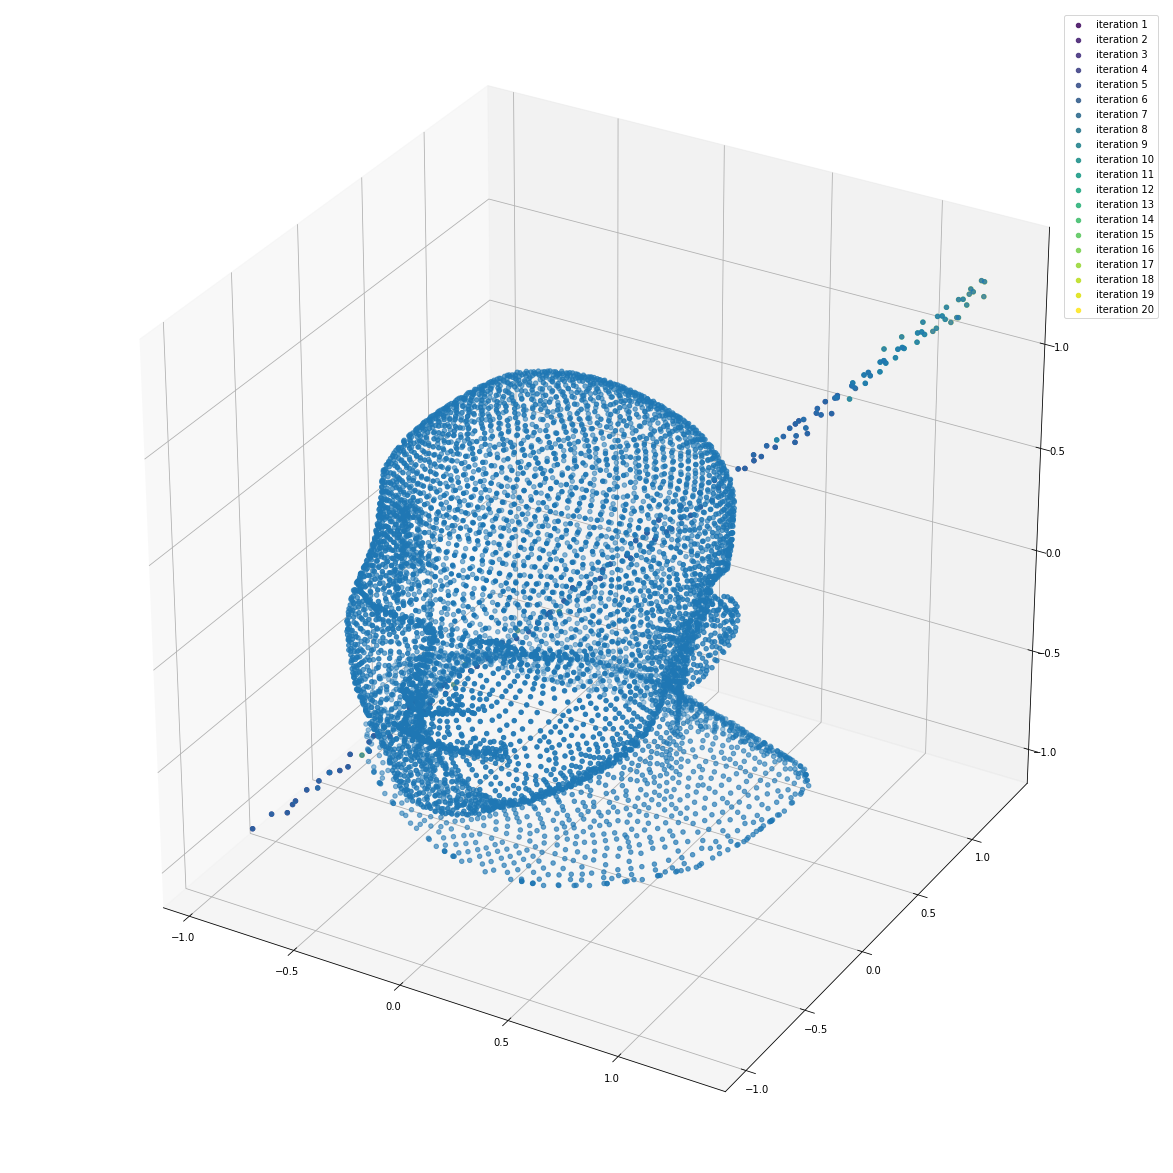

In [13]:
fig = plt.figure(figsize=(16,16))
ax = Axes3D(fig)

#sample = testArr[np.random.randint(len(testArr))]

#print (sample.shape)

#edge_pts = sample[sample[:, 6] == True, 0:3]
#non_edge_pts = sample[sample[:, 6] == False, 0:3]

#ax.scatter(
#    origin_points[:,0],
#    origin_points[:,1],
#    origin_points[:,2],
#    color = 'grey',
#    label = 'input',
#    s = 100
#)

ax.scatter(points[:,0], points[:,1], points[:,2])

for i in range(len(extra_points)):
    
    fac = (i+1) / len(extra_points)
    
    ax.scatter(
        extra_points[i][:,0],
        extra_points[i][:,1],
        extra_points[i][:,2],
        alpha = 0.9,
        label = "iteration %d" % (i+1),
        color = matplotlib.cm.get_cmap('viridis')(fac),
        s = 20
    )

ax.legend()

#ax.scatter(non_edge_pts[:,0], non_edge_pts[:,1], non_edge_pts[:,2])
#ax.scatter(edge_pts[:,0], edge_pts[:,1], edge_pts[:,2])

#plt.show()

plt.savefig("example_3d.png", dpi = 200)